# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


The first stage of sampling happens when 10% of the people (100 out of 1,000) are randomly picked to be infected. 
This is done using np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False), which performs simple random sampling without replacement from the full list of individuals. Everyone has an equal chance of getting infected, no matter which event they attended.

The second stage is primary contact tracing, where each infected person has a 20% chance of being traced. 
This is done using the line (np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS), which ends up tracing about 20 people. 

Then the third stage, secondary contact tracing, which adds some bias. If an event, like a wedding or brunch, has at least two traced infected people, then all the other infected people at that same event are also marked as traced. This rule tends to over-sample people from bigger events, so brunches (which have more attendees) are more likely to hit that threshold and show up more in the traced data.

Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

To explore the impact of sample size on the reproducibility of results, I modified the number of simulation repetitions from the original 1000 to 100 and then to 10. After running the script multiple times, I observed the behavior of the outputted histograms.

When the loop was run 1000 times, the results appeared stable and consistent across different runs. The histograms showed smooth, bell-shaped distributions that reflected the underlying randomness of the model in a balanced way. However, as the number of repetitions decreased to 100 and especially to 10, the graphs looked more uneven and changed quite a bit each time I ran the code. This makes sense because smaller sample sizes are more affected by random chance, and since there’s no fixed seed, the results are different every time.

As a result, the reproducibility of the output decreases with fewer repetitions. With only 10 or 100 runs, different executions of the script can lead to significantly different histograms due to the randomness.

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

To make the code reproducible, I added random.seed(3) and np.random.seed(3) at the start. This sets the random number generators to always produce the same results, so every time the script runs, the infections, tracing, and outputs stay exactly the same. Without these seeds, the results would change each run, but now the output is consistent and repeatable.

## Code

First random sample
       event  infected  traced
0    wedding     False    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding     False    <NA>
4    wedding     False    <NA>
..       ...       ...     ...
995   brunch     False    <NA>
996   brunch     False    <NA>
997   brunch     False    <NA>
998   brunch     False    <NA>
999   brunch      True    <NA>

[1000 rows x 3 columns]
Secondary tracing
       event  infected  traced
0    wedding     False    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding     False    <NA>
4    wedding     False    <NA>
..       ...       ...     ...
995   brunch     False    <NA>
996   brunch     False    <NA>
997   brunch     False    <NA>
998   brunch     False    <NA>
999   brunch      True    True

[1000 rows x 3 columns]
First random sample
       event  infected  traced
0    wedding      True    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding      True  

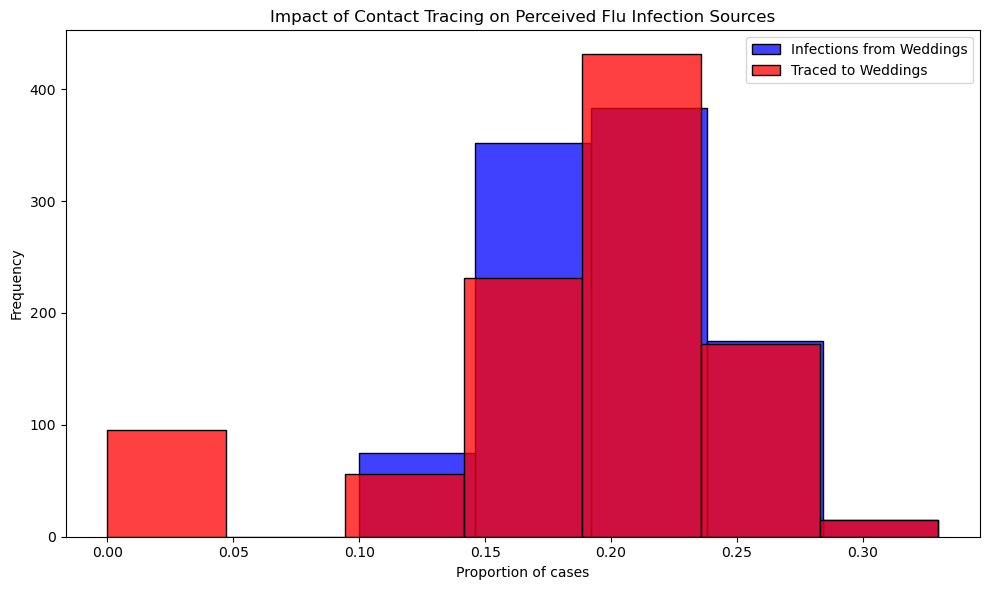

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
random.seed(3)
np.random.seed(3)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True
  print("First random sample")
  print(ppl)

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True
  print("Secondary tracing")
  print(ppl)

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
print(props_df)
# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()


## Criteria

First random sample
       event  infected  traced
0    wedding     False    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding     False    <NA>
4    wedding     False    <NA>
..       ...       ...     ...
995   brunch     False    <NA>
996   brunch      True    <NA>
997   brunch     False    <NA>
998   brunch     False    <NA>
999   brunch     False    <NA>

[1000 rows x 3 columns]
Secondary tracing
       event  infected  traced
0    wedding     False    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding     False    <NA>
4    wedding     False    <NA>
..       ...       ...     ...
995   brunch     False    <NA>
996   brunch      True    True
997   brunch     False    <NA>
998   brunch     False    <NA>
999   brunch     False    <NA>

[1000 rows x 3 columns]
First random sample
       event  infected  traced
0    wedding      True    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding     False  

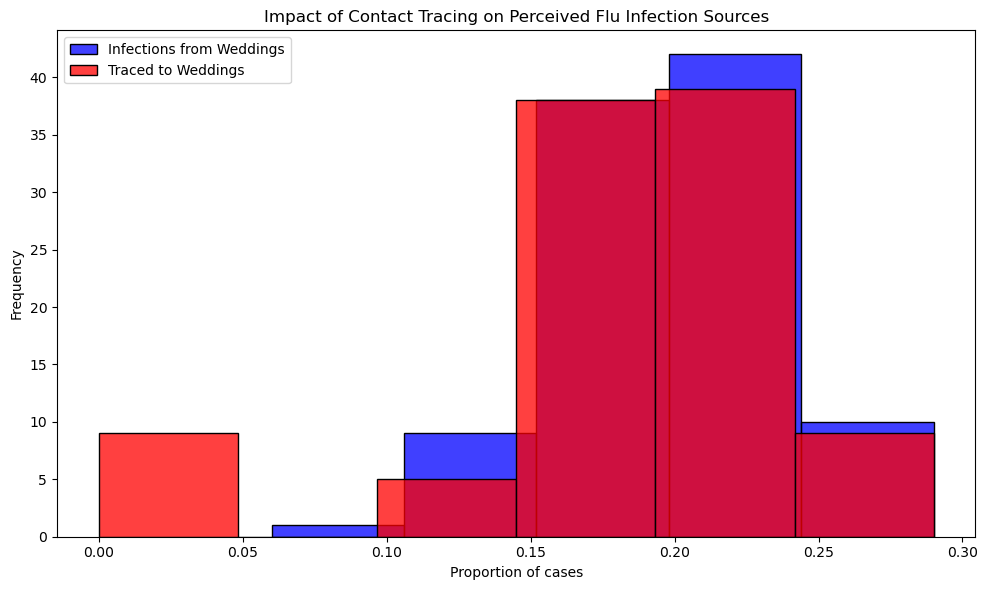

In [10]:
random.seed(4)
np.random.seed(4)

results = [simulate_event(m) for m in range(100)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
print(props_df)
# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

First random sample
       event  infected  traced
0    wedding     False    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding      True    <NA>
4    wedding     False    <NA>
..       ...       ...     ...
995   brunch     False    <NA>
996   brunch     False    <NA>
997   brunch     False    <NA>
998   brunch     False    <NA>
999   brunch     False    <NA>

[1000 rows x 3 columns]
Secondary tracing
       event  infected  traced
0    wedding     False    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding      True   False
4    wedding     False    <NA>
..       ...       ...     ...
995   brunch     False    <NA>
996   brunch     False    <NA>
997   brunch     False    <NA>
998   brunch     False    <NA>
999   brunch     False    <NA>

[1000 rows x 3 columns]
First random sample
       event  infected  traced
0    wedding     False    <NA>
1    wedding     False    <NA>
2    wedding     False    <NA>
3    wedding     False  

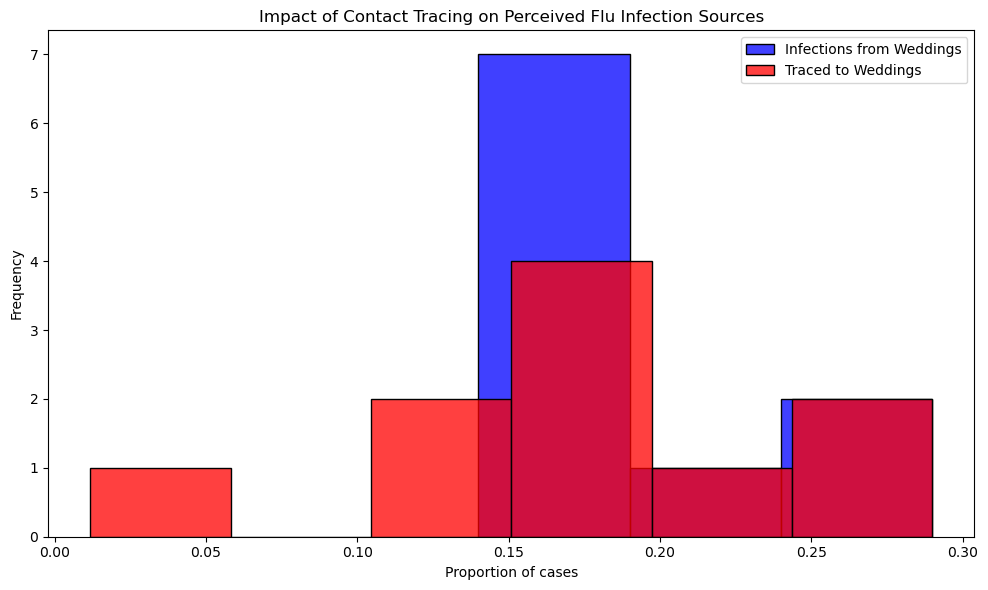

In [13]:
random.seed(5)
np.random.seed(5)

results = [simulate_event(m) for m in range(10)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
print(props_df)
# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 22/06/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
